In [2]:
import pyspark as spark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName('text_summarization')\
    .config('spark.some.config.option','some-value') \
    .getOrCreate()

In [3]:
review = spark.read.json('review.json')

In [4]:
tip = spark.read.json('tip.json')

In [5]:
tip.createOrReplaceTempView("tip")
review.createOrReplaceTempView("review")
tip_review_pair = spark.sql('SELECT tip.business_id, tip.user_id, tip.text as tip_text, review.text as review_text FROM tip, review WHERE tip.business_id = review.business_id and tip.user_id = review.user_id and length(tip.text) > 20')

In [5]:
tip_review_pair.count()

488400

In [6]:
test_tip_review_pair = tip_review_pair.select('review_text','tip_text')

In [7]:
reviews_rdd = test_tip_review_pair.select("review_text").rdd.flatMap(lambda x: x)

In [8]:
def text_summarize(x):
    import sumy
    from sumy.parsers.plaintext import PlaintextParser
    from sumy.nlp.tokenizers import Tokenizer
    from sumy.summarizers.lex_rank import LexRankSummarizer
    parser = PlaintextParser.from_string(x,Tokenizer("english"))
    summarizer = LexRankSummarizer()
    summary = summarizer(parser.document, 1)
    for sent in summary:
        return str(sent)

In [9]:
summarized_review1 = reviews_rdd.map(text_summarize)

In [9]:
type(summarized_review1)

pyspark.rdd.PipelinedRDD

In [11]:
summarized_review1.take(5)

['The place is cleaner and cheaper than other Mexican markets.',
 'This store always has ONE employee whose always busy helping the incoming customers.',
 'Service was very friendly!',
 'The concept of the added spices is great on fries, but the sweet potato fries looked double fried, completely different than the regular fries my friend had.',
 'A+ from start to finish!']

In [14]:
# from pyspark.sql import Row
# row = Row("summarized_review")
# summarized_review1_df = summarized_review1.map(row).toDF()

In [16]:
# summarized_review1_df.show(5,False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------+
|summarized_review                                                                                                                                            |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------+
|The place is cleaner and cheaper than other Mexican markets.                                                                                                 |
|This store always has ONE employee whose always busy helping the incoming customers.                                                                         |
|Service was very friendly!                                                                                                                                   |
|The concept of the added spices is grea

In [23]:
# import pyspark.sql.functions as f

In [24]:
# test_tip_review_pair=test_tip_review_pair.withColumn('row_index', f.monotonically_increasing_id())
# summarized_review1_df=summarized_review1_df.withColumn('row_index', f.monotonically_increasing_id())

In [25]:
# minDf = test_tip_review_pair.join(summarized_review1_df, on=["row_index"]).sort("row_index").drop("row_index")

In [ ]:
# minDf.show(5)

In [10]:
tip_rdd = test_tip_review_pair.select("tip_text").rdd.flatMap(lambda x: x)

In [13]:
tip_rdd.take(5)

['The place is cleaner and cheaper than other Mexican markets.',
 'Still a shitty experience.',
 'Pumpkin pie ice cream',
 'Discontinued goat cheese - if pepper jack lets me down today I may have to give up on burgers! Grr',
 'A+ from start to finish!']

In [11]:
#nltk
def word_tokenize(x):
    import nltk
    return nltk.word_tokenize(x)

In [12]:
def remove_punctuation(x):
    import re, string
    list_punct=list(string.punctuation)
    out = [ch for ch in x if ch not in list_punct]
    return out

In [13]:
def remove_stop_words(x):
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
    filteredSentence = [w.lower() for w in x if w.isalpha() if w.lower() not in stop_words]
    return filteredSentence

In [14]:
def lemmatize(x):
    import nltk
    wnl = nltk.WordNetLemmatizer()
    lemmatize = [wnl.lemmatize(w) for w in x]
    return lemmatize 

In [15]:
def pos_of_tags(x):
    import nltk
    POS_tags = nltk.pos_tag(x)
    return POS_tags

In [16]:
def sentiment_score(x):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    sid = SentimentIntensityAnalyzer() 
    ss = sid.polarity_scores(x)
    return ss

In [17]:
tip_ss = tip_rdd.map(sentiment_score)

In [18]:
summarized_review1_ss = reviews_rdd.map(text_summarize).map(sentiment_score)

In [21]:
type(tip_ss)

pyspark.rdd.PipelinedRDD

In [22]:
tip_ss.take(5)

[{'neg': 0.0, 'neu': 0.841, 'pos': 0.159, 'compound': 0.1779},
 {'neg': 0.643, 'neu': 0.357, 'pos': 0.0, 'compound': -0.5574},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}]

In [24]:
summarized_review1_ss.take(5)

[{'neg': 0.0, 'neu': 0.841, 'pos': 0.159, 'compound': 0.1779},
 {'neg': 0.0, 'neu': 0.845, 'pos': 0.155, 'compound': 0.296},
 {'neg': 0.0, 'neu': 0.442, 'pos': 0.558, 'compound': 0.5838},
 {'neg': 0.0, 'neu': 0.689, 'pos': 0.311, 'compound': 0.8968},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}]

In [19]:
# select 500 compound score to visulize wo see difference between score of tip and summary
tip_distribution = tip_ss.take(500)

In [26]:
type(tip_distribution)

list

In [27]:
tip_distribution

[{'neg': 0.0, 'neu': 0.841, 'pos': 0.159, 'compound': 0.1779},
 {'neg': 0.643, 'neu': 0.357, 'pos': 0.0, 'compound': -0.5574},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 0.575, 'pos': 0.425, 'compound': 0.6341},
 {'neg': 0.0, 'neu': 0.575, 'pos': 0.425, 'compound': 0.6341},
 {'neg': 0.0, 'neu': 0.465, 'pos': 0.535, 'compound': 0.7841},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.392, 'neu': 0.291, 'pos': 0.317, 'compound': -0.1316},
 {'neg': 0.199, 'neu': 0.622, 'pos': 0.179, 'compound': -0.0654},
 {'neg': 0.0, 'neu': 0.719, 'pos': 0.281, 'compound': 0.5994},
 {'neg': 0.0, 'neu': 0.673, 'pos': 0.327, 'compound': 0.5267},
 {'neg': 0.0, 'neu': 0.548, 'pos': 0.452, 'compound': 0.877},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 0.504, 'pos': 0.496, 'compound': 0.9151},
 {'neg': 0.0, 'neu': 

In [20]:
import pandas as pd
df_tip = pd.DataFrame(data=tip_distribution)

In [29]:
df_tip

,compound,neg,neu,pos
0,0.1779,0.000,0.841,0.159
1,-0.5574,0.643,0.357,0.000
2,0.0000,0.000,1.000,0.000
3,0.0000,0.000,1.000,0.000
4,0.0000,0.000,1.000,0.000
5,0.6341,0.000,0.575,0.425
6,0.6341,0.000,0.575,0.425
7,0.7841,0.000,0.465,0.535
8,0.0000,0.000,1.000,0.000
9,-0.1316,0.392,0.291,0.317


In [21]:
summary_distribution = summarized_review1_ss.take(500)

In [22]:
df_summary = pd.DataFrame(data=summary_distribution)

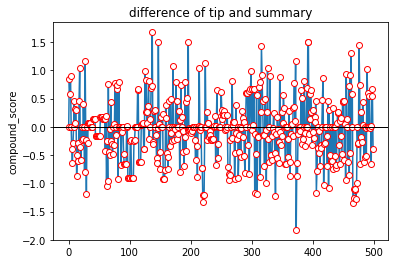

In [23]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
arr1 = df_summary['compound'].values
arr2 = df_tip['compound'].values
arr = arr1-arr2
x = range(len(arr1))
plt.plot(x, arr, marker='o', mec='r', mfc='w')
plt.axhline(linewidth=1, color='black')
plt.ylabel("compound_score") 
plt.title("difference of tip and summary")
plt.show()

C:\Users\AndyZ\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


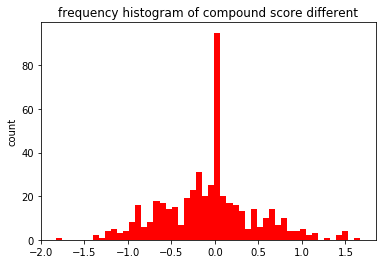

In [26]:
plt.figure("hist")
arr3 =arr.flatten()
plt.title("frequency histogram of compound score different")
plt.ylabel("count") 
n, bins, patches = plt.hist(arr3, bins=50, normed=0,edgecolor='None',facecolor='red')  
plt.show()


In [34]:
# transfer rdd to df
from pyspark.sql import Row
row = Row("summarized_review")
summarized_review1_df = summarized_review1.map(row).toDF()

In [35]:
summarized_review1_df.show(5,False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------+
|summarized_review                                                                                                                                            |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------+
|The place is cleaner and cheaper than other Mexican markets.                                                                                                 |
|This store always has ONE employee whose always busy helping the incoming customers.                                                                         |
|Service was very friendly!                                                                                                                                   |
|The concept of the added spices is grea

In [26]:
summarized_review_tokens = reviews_rdd.map(text_summarize).map(word_tokenize).map(remove_punctuation)

In [27]:
tip_tokens = tip_rdd.map(word_tokenize).map(remove_punctuation)

In [20]:
type(summarized_review_tokens)

pyspark.rdd.PipelinedRDD

In [28]:
summary_tokens = summarized_review_tokens.take(500)

In [29]:
type(summary_tokens)

list

In [31]:
tip_tokens = tip_tokens.take(500)

In [48]:
from nltk.translate.bleu_score import sentence_bleu
reference = tip_tokens
candidate = summary_tokens

score = sentence_bleu([reference[5]], candidate[5])
print(score)

0.513417119032592
